Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


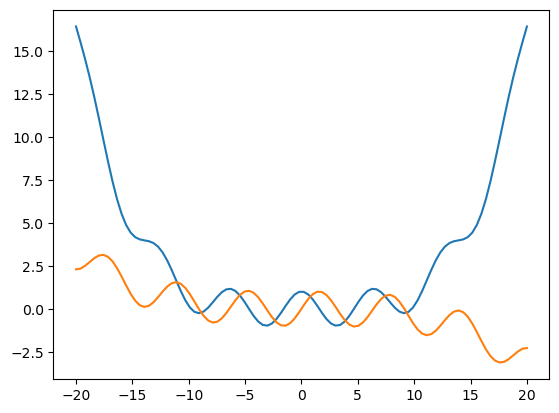

In [1]:
import propagators
import energy_landscapes
import long_simulation
import weighted_ensemble_2
import numpy as np
import MSM_methods
import analysis

import matplotlib.pyplot as plt
import importlib

importlib.reload(energy_landscapes)

#methods for fast print debugging
def p(x):
    print(x)
def pl(x):
    print(len(x))
def ps(x):
    print(x.shape)

kT = 1
dt = 0.001
nbins = 160
save_period = 100 #in steps; used to set nsteps below
n_bootstrap = 3

system1 = energy_landscapes.unit_sine_well()
system1.plot_quantity(system1.potential)
system1.plot_quantity(system1.F)
#system1.analysis_bins(40)


In [1]:
importlib.reload(MSM_methods)
importlib.reload(long_simulation)

mfpts_long_raw = []
mfpts_long_hamsm = []

for bs in range(n_bootstrap):

    print(bs)

    x_init_coord = system1.standard_init_coord
    nsteps = 100000
    n_parallel = 1000
    lag_time = 1

    long_trjs = long_simulation.run_long_parallel_simulations(propagators.propagate, system1, kT, dt, nsteps, save_period, n_parallel)
    print(f"simulation steps:\n Aggregate: {nsteps*n_parallel} \n Molecular: {nsteps}")


    #------------------------------------------------------------------------------------------
    #non-MSM analysis
    x, p = long_simulation.estimate_eq_pops_histogram(long_trjs, system1, nbins)
    transitions, mfpts = long_simulation.calc_mfpt(system1.macro_class, system1.n_macrostates, save_period, long_trjs)
    if n_bootstrap == 1:
        metrics = analysis.landscape_comparison(system1, kT, x, p, metrics = ["maew"])
        analysis.print_mfpts_2states(mfpts)

    inter_well_mpfts = [mfpts[0,1], mfpts[1,0]]
    mfpts_long_raw.append(np.mean(inter_well_mpfts))


    #------------------------------------------------------------------------------------------
    #MSM analysis
    # x_msm, eqp_msm, mfpts_msm = long_simulation.msm_analysis(long_trjs, nbins, system1.macro_class, system1.n_macrostates(), save_period, lag_time=lag_time, show_TPM=False)
    # metrics = analysis.landscape_comparison(system1, kT, x_msm, eqp_msm, metrics = ["maew"])

    # analysis.print_mfpts_2states(mfpts_msm)


    #TODO as a more stringent test break this into two cells: 
    # In the first calculate MFPTs from a single long trajectory by brute force, 
    # and in the second calculate them from many very short (too short to get accurate brute force results) ones with an MSM.
    # if you build an MSM from trajectories so long the system has equilibrated by brute force you could get accurate MFPTs even if there's something wrong with MSM construction
    #------------------------------------------------------------------------------------------
    #haMSM analysis
    #note that lag time is measured in saved frames
    ha_transitions = long_simulation.get_ha_transitions(long_trjs, nbins, system1, lag_time=1)
    x_hamsm, eqp_hamsm, x_ens, p_ens, mfpts_hamsm = analysis.hamsm_analysis(ha_transitions, nbins, system1, save_period, lag_time=1, show_TPM=False)
    #long_simulation.hamsm_analysis(long_trjs, nbins, system1, save_period, lag_time=1, show_TPM=False)
    if n_bootstrap == 1:
        metrics = analysis.landscape_comparison(system1, kT, x_hamsm, eqp_hamsm, metrics = ["maew"], ensemble_data = [x_ens, p_ens])
        analysis.print_mfpts_2states(mfpts_hamsm)

    inter_well_mpfts_hamsm = [mfpts_hamsm[0,1], mfpts_hamsm[1,0]]
    mfpts_long_hamsm.append(np.mean(inter_well_mpfts_hamsm))

plt.hist(mfpts_long_raw, alpha=0.5)
plt.hist(mfpts_long_hamsm, alpha=0.5)


NameError: name 'importlib' is not defined

# WE simulation

Each bin can hold up to 3 walkers, for a total of up to 486 walkers
0
400
800
1200
1600
2000
2400
2800
3200
3600
simulation steps:
 Aggregate: 31448700 
 Molecular: 400000
eigenvector converged to within 10^-12 after 0 rounds
Each bin can hold up to 3 walkers, for a total of up to 486 walkers
0
400
800
1200
1600
2000
2400
2800
3200
3600
simulation steps:
 Aggregate: 31454400 
 Molecular: 400000
eigenvector converged to within 10^-12 after 0 rounds
Each bin can hold up to 3 walkers, for a total of up to 486 walkers
0
400
800
1200
1600
2000
2400
2800
3200
3600
simulation steps:
 Aggregate: 31222200 
 Molecular: 400000
eigenvector converged to within 10^-12 after 0 rounds
Each bin can hold up to 3 walkers, for a total of up to 486 walkers
0
400
800
1200
1600
2000
2400
2800
3200
3600
simulation steps:
 Aggregate: 31768100 
 Molecular: 400000
eigenvector converged to within 10^-12 after 0 rounds
Each bin can hold up to 3 walkers, for a total of up to 486 walkers
0
400
800
1200
1600
2000
240

(array([1., 1., 1., 0., 1., 0., 1., 1., 2., 2.]),
 array([ 985.40858694,  987.33732248,  989.26605803,  991.19479357,
         993.12352911,  995.05226465,  996.98100019,  998.90973573,
        1000.83847127, 1002.76720681, 1004.69594235]),
 <BarContainer object of 10 artists>)

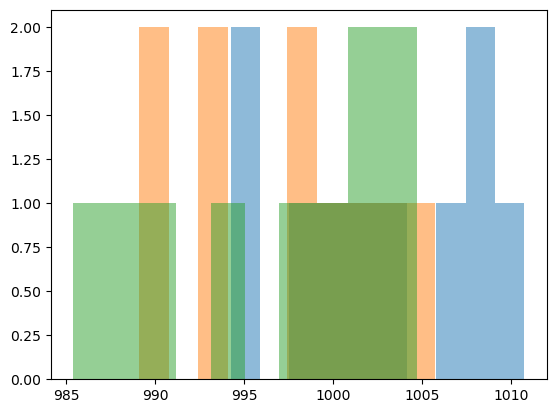

In [ ]:

mfpts_we_hamsm = []

for bs in range(n_bootstrap):
    #Weighted ensemble (WE) parameters and inputs

    N = 500             #total number of walkers within binrange
    #nbins = 40         #total number of bins within binrange 
    #nbins should match the value above, at least for analysis; make a separate n_bins_analysis variable

    walkers_per_bin = round(N/nbins)
    print(f"Each bin can hold up to {walkers_per_bin} walkers, for a total of up to {walkers_per_bin*(nbins+2)} walkers")

    binrange = system1.standard_analysis_range 

    #progress coordinate range within which to bin simulations
                        #this should extend well past the stall point for examination of the WE stall force
                        #the area past either end of binrange is a bin extending to either + or - inf, yielding a total of nbins+2 bins
    n_macrostates=2
            
    nsteps = save_period        #round length; to match long simulations since MFPT = f(lag time)
    nrounds = 4000              #number of WE rounds to run

    x_init_val = system1.standard_init_coord

    #run weighted ensemble with brownian dynamics
    #put this on multiple lines
    x_init, e_init, w_init, binbounds, xtrj, etrj, wtrj, transitions, hamsm_transitions, n_trans_by_round \
    = weighted_ensemble_2.weighted_ensemble_start(\
                        x_init_val,\
                        nrounds,\
                        nbins,\
                        walkers_per_bin,\
                        binrange, propagators.propagate_save1,\
                        [system1, kT, dt, nsteps],\
                        system1.ensemble_class,\
                        n_macrostates,\
                        ha_binning=False)


    aggregate_walkers = len([j for i in xtrj for j in i])
    print(f"simulation steps:\n Aggregate: {nsteps*aggregate_walkers} \n Molecular: {nsteps*nrounds}")

    x, p, xs, es = weighted_ensemble_2.landscape_recovery(xtrj, wtrj, binbounds, transitions, hamsm_transitions, n_trans_by_round, nrounds, n_macrostates, system1.potential, system1.macro_class, kT)

    x_hamsm, eqp_hamsm, x_ens, p_ens, mfpts_hamsm = analysis.hamsm_analysis(hamsm_transitions, nbins, system1, nsteps, lag_time=1, show_TPM=False)

    if n_bootstrap == 1:
        metrics = analysis.landscape_comparison(system1, kT, x_hamsm, eqp_hamsm, metrics = ["maew"], ensemble_data = [x_ens, p_ens])
        analysis.print_mfpts_2states(mfpts_hamsm)

    inter_well_mpfts_we_hamsm = [mfpts_hamsm[0,1], mfpts_hamsm[1,0]]
    mfpts_we_hamsm.append(np.mean(inter_well_mpfts_we_hamsm))


plt.hist(mfpts_long_raw, alpha=0.5)
plt.hist(mfpts_long_hamsm, alpha=0.5)
plt.hist(mfpts_we_hamsm, alpha=0.5)


In [ ]:
#IDEA: can populate bins by resuming previously-terminated walkers, especially deeply-branching ones; could include these 'ghost' walkers in RMSD comparisons as well